In [510]:
import scipy
import scipy.io
import scipy.integrate
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Activation, Concatenate, Lambda, Multiply, Dot, Add
from tensorflow.keras import Model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from matplotlib.tri import *
import random


In [511]:
def rotate_e(xt, theta):
    alpha = np.deg2rad(theta)
    c = np.cos(alpha)
    s = np.sin(alpha)
    x = np.transpose(xt)
    # R = [[1, 0, 0], [0, 1, 0], [0, 0, 2]]
    # Rm = [[1, 0, 0], [0, 1, 0], [0, 0, .5]]
    T = [[c ** 2, s ** 2, s * c], [s ** 2, c ** 2, -s * c], [- 2 *s * c, 2 * s * c, c ** 2 - s ** 2]]
    # eps_ = np.transpose(np.matmul(rot, x))
    eps_ = np.transpose(np.matmul(T, x))
    return eps_


def rotate_s(x, theta):
    alpha = np.deg2rad(theta)
    c = np.cos(alpha)
    s = np.sin(alpha)
    # x = np.transpose(xt)
    T = [[c ** 2, s ** 2, 2 * s * c], [s ** 2, c ** 2, -2 * s * c], [s * c, s * c, c ** 2 - s ** 2]]
    Tinv = np.linalg.inv(T)
    x_ = np.transpose(np.matmul(Tinv, x))
    return x_

In [513]:
class TestData:
    def __init__(self, folder, filename, remove_frames=0, angle='auto', shear='eng'):
        if filename[-4:] != '.mat':
            filename = filename + '.mat'
        self.name = filename
        self.data = scipy.io.loadmat(folder+'\\'+filename)
        self.nelem = np.squeeze(self.data['nelem']).astype(int)
        self.remove_frames = remove_frames

        self.d = self.data['d']
        self.f = self.data['F']
        self.W = 2*np.abs(scipy.integrate.cumtrapz(self.f, self.d, axis=0, initial=0))
        self.n_frames = int(self.data['d'].shape[0] - remove_frames)
        self.eps = self.data['EPS'][:self.n_frames*self.nelem, :]
        self.eps_raw = self.data['EPS'][:self.n_frames*self.nelem, :]
        if shear == 'true':
            self.eps[:, 2] = 2 * self.eps[:, 2]
            self.eps_raw[:, 2] = 2 * self.eps_raw[:, 2]
        self.We = np.repeat(self.W, self.nelem, axis=0)
        self.area = self.data['area']
        self.nodes, self.coordinates = self.data['nodes'], self.data['coordinates']
        self.theta = 0
        self.train_data = None
        self.X = self.data['X']
        self.Y = self.data['Y']
        self.kmean = None
        self.labels = None
        self.centers = None
        if angle=='auto':
            if filename[0] == 'A':
                angle = 45
            else:
                angle = 0
        self.angle = angle
        self.rotate(self.angle)

        self.x_test = None
        self.x_train = None
        self.y_train = None
        self.y_test = None
        
    def cluster(self, n_clusters):
        x = self.eps_raw
        x[x < 1e-5] = 0
        xu, ic = np.unique(x, return_inverse=True, axis=0)
        print('Finding unique values ..')
        pca = PCA(n_components=2).fit(xu)
        print('Computing Principal Components ..')
        xu_pca = pca.transform(xu)
        print('Clustering ..')
        kmean = KMeans(n_clusters=n_clusters).fit(xu_pca)
        xu_cluster = pca.inverse_transform(kmean.cluster_centers_)[kmean.labels_, :]
        x_clustered = xu_cluster[ic, :]
        self.eps = x_clustered
        self.labels = kmean.labels_[ic]
        self.kmean = kmean
        self.centers = pca.inverse_transform(kmean.cluster_centers_)

    def __str__(self):
        return f"{self.name} has {self.nelem} elements"

    def rotate(self, alpha):
        self.eps = rotate_e(self.data['EPS'], alpha)
        self.theta += alpha

    def mirror(self):
        self.eps = np.concatenate((self.eps, rotate_e(self.eps, self.theta - 90)))
        self.We = np.concatenate((self.We, self.We))

    def prepare(self, test_split=0.2):
        test_size = np.round(test_split * self.n_frames).astype(int)
        test_frames = np.sort(
            np.random.choice(
                self.n_frames,
                np.squeeze(test_size), replace=False).astype(int))
        train_frames = np.setdiff1d(np.arange(self.n_frames), test_frames).astype(int)
        x_test = np.zeros((1, self.eps.shape[1]))
        x_train = np.zeros((1, self.eps.shape[1]))
        y_test = np.zeros((1, 1))
        y_train = np.zeros((1, 1))
        for i in np.arange(test_frames.shape[0]):
            x_test = np.append(x_test,
                               self.eps[np.arange(test_frames[i] * self.nelem, test_frames[i] * self.nelem + self.nelem).astype(int), :],
                               axis=0)
            y_test = np.append(y_test,
                               self.We[np.arange(test_frames[i] * self.nelem, test_frames[i] * self.nelem + self.nelem).astype(int),
                               :], axis=0)
        for i in np.arange(train_frames.shape[0]):
            x_train = np.append(x_train,
                                self.eps[np.arange(train_frames[i] * self.nelem, train_frames[i] * self.nelem + self.nelem).astype(int), :],
                                axis=0)
            y_train = np.append(y_train, self.We[
                                         np.arange(train_frames[i] * self.nelem, train_frames[i] * self.nelem + self.nelem).astype(
                                             int), :], axis=0)
        self.x_test = x_test[1:, :]
        self.x_train = x_train[1:, :]
        self.y_train = y_train[1:, :]
        self.y_test = y_test[1:, :]

        print('The real test size is: ' + str(100 * x_test.shape[0] / (x_test.shape[0] + x_train.shape[0])) + ' %')

        return self.x_train, self.x_test, self.y_train, self.y_test



In [514]:
 class pinn_model:
    def __init__(self, norm=False):
        self.net = None
        self.sub_net = None
        self.norm = norm
        self.hist = None
        self.train_data = None
        self.Xscaler = None
        self.Yscaler = None
        self.x_train, self.y_train = None, None
        self.x_test, self.y_test = None, None
            
    def build_e(self, n_layers, n_neurons, act_fun, thickness, area):        
        # Input layer
        strains = Input(shape=(3,), name='strains')
        strains_t = Reshape((1, 3))(strains)

        # Normalized
        strains_n = Input(shape=(3,), name='strains_n')
        strains_nt = Reshape((1, 3))(strains)

        # Common Hidden layers
        if self.norm:
            hidden_tr = Dense(units=n_neurons, activation=act_fun)(strains_nt)
            hidden_dev = Dense(units=n_neurons, activation=act_fun)(strains_nt)
            for i in range(n_layers):
                hidden_tr = Dense(units=n_neurons, activation=act_fun)(hiddent_tr)
                hidden_dev = Dense(units=n_neurons, activation=act_fun)(hidden_dev)
        else:
            hidden_tr = Dense(units=n_neurons, activation=act_fun)(strains_t)
            hidden_dev = Dense(units=n_neurons, activation=act_fun)(strains_t)
            for i in range(n_layers):
                hidden_tr = Dense(units=n_neurons, activation=act_fun)(hidden_tr)
                hidden_dev = Dense(units=n_neurons, activation=act_fun)(hidden_dev)

        trC = Dense(units=2, activation='relu', name='trC')(hidden_tr)
        devC = Dense(units=1, activation='relu')(hidden_dev)
        C = Concatenate(axis=-1, name='C')([trC, devC])
        
        if self.norm:
            trS = Multiply(name='out')([strains_n, trC])
            Utr = Dot(axes=1)([strains_nt, trS])
        else:
            S = Multiply(name='out')([strains_t, C])
            Utr = Dot(axes=2)([strains_t, S])

        # Compute the internal energy
        if self.norm:
            self.net = Model(inputs=[strains, strains_n], outputs=Utr)
        else:
            self.net = Model(inputs=strains, outputs=Utr)
        self.net.summary()
        
    def compile_e(self, optimizer='adam', metrics=[], test_data=None, wdiv=0.99, wen=0.01):
        def divergence():
            x, y = test_data.X.flatten(), test_data.Y.flatten()
            # Select unconstrained points
            i_constrained = y == y.max()
            i_load = y == y.min()
            i_unconstrained = np.squeeze(i_load == i_constrained)
            # Select frames
            i = np.array(random.randint(0, test_data.x_train.shape[0] / test_data.nelem - 1))
            # Extract strains at frame i
            xe = test_data.x_train[i * test_data.nelem:(i + 1) * test_data.nelem, :][i_unconstrained, :]
            if model.norm:
                model_c = Model(
                    inputs=[model.net.get_layer('strains').input, model.net.get_layer('strains_n').input],
                    outputs=model.net.get_layer('out').output
                )
                xe_n = model.Xscaler.transform(xe)
                sig = model_c([xe, xe_n]).numpy() * model.Yscaler.scale_
            else:
                model_c = Model(inputs=model.net.get_layer('strains').input,
                                outputs=model.net.get_layer('out').output)
                sig = model_c(xe).numpy()
            sig_p = rotate_s(np.squeeze(sig).T, test_data.angle)
            #x, y = test_data.X.flatten(), test_data.Y.flatten()
            tri = Triangulation(x[i_unconstrained], y[i_unconstrained])
            Fx = LinearTriInterpolator(tri, sig_p[:, 0] + sig_p[:, 2])
            Fy = LinearTriInterpolator(tri, sig_p[:, 1] + sig_p[:, 2])
            gradx = Fx.gradient(x[i_unconstrained], y[i_unconstrained])
            grady = Fy.gradient(x[i_unconstrained], y[i_unconstrained])
            div = gradx[0] + grady[0] + gradx[1] + grady[1]
            Ldiv = tf.reduce_mean(tf.math.square(tf.constant(div.flatten())))
            return Ldiv

        def Ltot(y_true, y_pred):
            Wi = tf.reduce_sum(y_pred, axis=0)
            We = tf.math.reduce_mean(y_true, axis=0)
            L_div = divergence()
            # L_en = tf.keras.metrics.mean_squared_error(external_work, system_internal_energy)
            L_en = tf.math.abs(Wi - We)
            loss = wen * tf.cast(L_en, dtype=tf.float64) + wdiv * L_div
            # print('Divergence error: {} - Energy error: {}'.format(0.99*L_div, 0.01*L_en))
            return loss

        self.net.compile(loss=Ltot, optimizer=optimizer, run_eagerly=True, metrics=metrics)

    def train(self, data, test_split=0.1):
        self.train_data = data
        early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        x_train, x_test, y_train, y_test = data.prepare(test_split)
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        if self.norm:
            sx = MinMaxScaler()
            x_train_n = sx.fit_transform(x_train)
            sy = StandardScaler(with_mean=False)
            y_train_n = sy.fit_transform(y_train)
            self.Xscaler = sx
            self.Yscaler = sy

            self.hist = self.net.fit([x_train, x_train_n], y_train_n,
                                     validation_data=([x_test, sx.transform(x_test)], sy.transform(y_test)),
                                     batch_size=data.nelem,
                                     epochs=1000,
                                     shuffle=False, callbacks=[early_stop],
                                     verbose=1)
        else:
            self.hist = self.net.fit(x_train, y_train,
                                     validation_data=(x_test, y_test),
                                     batch_size=data.nelem,
                                     epochs=1000,
                                     shuffle=False, callbacks=[early_stop],
                                     verbose=1)



In [515]:
test_data = TestData('Damage_orthotropic_balanced', 'tensile_10', remove_frames=5, angle=46, shear='true')
test_data.mirror()
# # test_data.cluster(n_clusters=100)
# x_train, x_test, y_train, y_test = test_data.prepare(test_split=0.1)
thickness = 0.66*4

In [516]:
# %% Create and train the model
model = pinn_model(norm=False)
model.build_e(n_layers=3, n_neurons=10, act_fun='tanh', thickness=thickness, area=test_data.area)
model.compile_e(optimizer=tf.keras.optimizers.Adam(), test_data=test_data, wdiv=0.98, wen=0.02)
model.train(data=test_data, test_split=0.1)

Model: "model_645264"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
strains (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
reshape_214 (Reshape)           (None, 1, 3)         0           strains[0][0]                    
__________________________________________________________________________________________________
dense_795 (Dense)               (None, 1, 10)        40          reshape_214[0][0]                
__________________________________________________________________________________________________
dense_796 (Dense)               (None, 1, 10)        40          reshape_214[0][0]                
_______________________________________________________________________________________

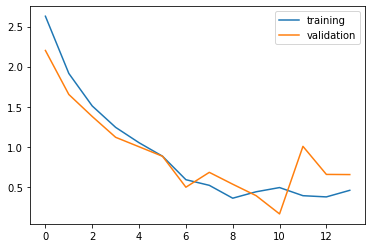

In [517]:
# Plot loss 
plt.plot(model.hist.history['loss'], label='training')
plt.plot(model.hist.history['val_loss'], label='validation')
# plt.ylim(0, 0.6)
plt.legend()

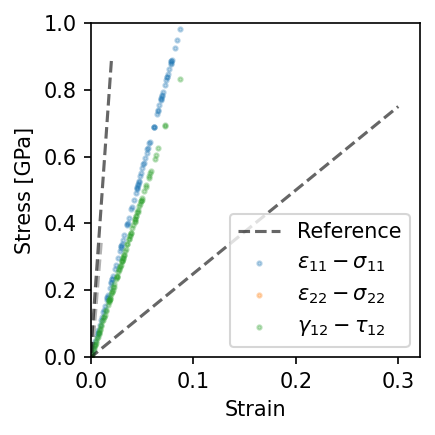

In [518]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Helvetica"

# Plot predicted stress-strain
# print(model.net.summary())
plt.figure(dpi=150, figsize = [3, 3])
model_s = Model(model.net.get_layer('strains').input, model.net.get_layer('out').output)
S = model_s.predict(test_data.x_train)
ex = np.linspace(-0.01, 0.02, 100)
ey = np.linspace(-0.01, 0.01, 100)
gxy = np.linspace(-0.1, 0.3, 100)
E1, E2, v12, v21, G12 = 48, 48, 0.14, 0.14, 2.5
skip = np.round(model.x_train.shape[0]/100, decimals=0).astype(int)
# Plot e1 vs s1
plt.scatter(model.x_train[::skip, 0], S[::skip, 0, 0], s=4, alpha=0.3, label='$\\varepsilon_{11} - \sigma_{11}$')
plt.plot(ex, E1*(ex)-v12*E2*ey, linestyle='--', alpha=.6, color='black', label='Reference')
# Plot e2 vs s2
# plt.figure()
plt.scatter(model.x_train[::skip, 1],  S[::skip, 0, 1], s=4, alpha=0.3, label='$\\varepsilon_{22} - \sigma_{22}$')
plt.plot(ey, E2*ey-v21*E1*ex, linestyle='--', alpha=.3, color='black')
# Plot gamma12 vs tau12
# plt.figure()
plt.scatter(model.x_train[::skip, 2], S[::skip, 0, 2], s=4, alpha=0.3, label='$\\gamma_{12} - \\tau_{12}$')
plt.plot(gxy, G12*gxy, linestyle='--', alpha=.6, color='black')
plt.xlabel('Strain'), plt.ylabel('Stress [GPa]')
plt.ylim(0, 1), plt.xlim(0,)
plt.legend()
plt.tight_layout()
# plt.savefig('Ortho_elastic.png', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)

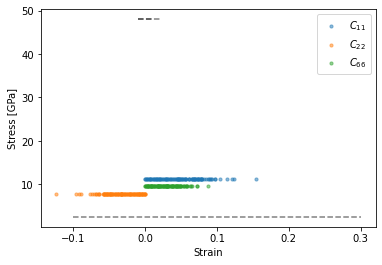

In [519]:
# Plot predicted stiffness
plt.figure()
model_c = Model(model.net.get_layer('strains').input, model.net.get_layer('C').output)
C = model_c.predict(model.x_train)
# Plot e1 vs C11
plt.scatter(model.x_train[::skip, 0], C[::skip, 0, 0], s=10, alpha=0.5, label='$C_{11}$')
plt.plot(ex, ex*0+E1, linestyle='--', alpha=.5, color='black')
# Plot e2 vs C22
plt.scatter(model.x_train[::skip, 1], C[::skip, 0, 1], s=10, alpha=0.5, label='$C_{22}$')
plt.plot(ey, ey*0+E2, linestyle='--', alpha=.5, color='black')
# Plot gamma12 vs C66
plt.scatter(model.x_train[::skip, 2], C[::skip, 0, 2], s=10, alpha=0.5, label='$C_{66}$')
plt.plot(gxy, 0*gxy+G12, linestyle='--', alpha=.5, color='black')
plt.xlabel('Strain'), plt.ylabel('Stress [GPa]')
# plt.ylim(-1, 1)
plt.legend()

In [484]:
# Optimize architecture
test_data = TestData('tensile_15', remove_frames=0, angle=15, shear='true')
test_data.mirror()
x_train, x_test, y_train, y_test = test_data.prepare(test_split=0.01)
thickness = 0.66*4

n_neurons = np.arange(10, 35, 5)
n_layers = np.arange(3, 11)
models = []
losses = []
for nn in n_neurons:
    for nl in n_layers:
        model = pinn_model(norm=False)
        model.build_e(n_layers=nl, n_neurons=nn, act_fun='tanh', thickness=thickness, area=test_data.area)
        model.compile_e(optimizer=tf.keras.optimizers.Adam(), test_data=test_data, wdiv=0.95, wen=0.05)
        model.train(data=test_data, test_split=0.01)
        models.append(model)
        losses.append(model.hist.history['loss'][-1])

TypeError: __init__() missing 1 required positional argument: 'filename'

Best configuration: 9 layers with 10 neurons


ValueError: x and y must be the same size

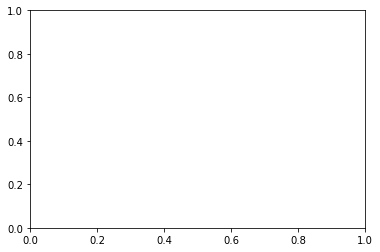

In [278]:
nl_doe = np.repeat(n_layers, n_neurons.shape[0])
nn_doe = np.tile(n_neurons, n_layers.shape[0])
print(
    'Best configuration: {} layers with {} neurons'.format(
    nl_doe[np.argmin(np.array(losses))], nn_doe[np.argmin(np.array(losses))]
    )
)
model = models[np.argmin(np.array(losses))]
# Plot predicted stress-strain
model_s = Model(model.net.get_layer('strains').input, model.net.get_layer('out').output)
S = model_s.predict(test_data.x_train)
ex = np.linspace(-0.01, 0.02, 100)
ey = np.linspace(-0.01, 0.01, 100)
gxy = np.linspace(-0.1, 0.3, 100)
E1, E2, v12, v21, G12 = 48, 48, 0.14, 0.14, 2.5
# Plot e1 vs s1
plt.scatter(x_train[::1000, 0], S[::1000, 0, 0], s=4, alpha=0.3, label='$\\varepsilon_{11} - \sigma_{11}$')
plt.plot(ex, E1*(ex), linestyle='--', alpha=.6, color='black')
# Plot e2 vs s2
plt.scatter(x_train[::1000, 1], S[::1000, 0, 1], s=4, alpha=0.3, label='$\\varepsilon_{22} - \sigma_{11}$')
plt.plot(ey, E2*ey-v21*E1*ex, linestyle='--', alpha=.3, color='black')
# Plot gamma12 vs tau12
plt.scatter(x_train[::1000, 2], S[::1000, 0, 2], s=4, alpha=0.3, label='$\\gamma_{12} - \\tau_{12}$')
plt.plot(gxy, G12*gxy, linestyle='--', alpha=.6, color='black')
plt.xlabel('Strain'), plt.ylabel('Stress [GPa]')
plt.ylim(0, 1), plt.xlim(0,)
plt.legend()



In [301]:
data = scipy.io.loadmat('Standard_test/A20_2f_s50.mat')
print(data['F'].shape/43520)
print(data['d'].shape)
print(data['nelem'])

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'